In [0]:
#Importing Library
import pyspark
from pyspark.sql import SparkSession

#Creation of SparkSession
spark = SparkSession.builder.getOrCreate()

In [0]:
#dbutils.fs.ls('dbfs:/FileStore/tables/')
#dbutils.fs.cp('dbfs:/FileStore/tables/skill2vec_50K_csv.gz','dbfs:/FileStore/tables/skill2vec_50K.csv.gz')

# These Commands are used to check the filepath
            

In [0]:
#Uploading dataset from database

filepath = "dbfs:/FileStore/tables/"

# To read the CSV file into a PySpark DataFrame
skill2vec_50K = spark.read.format("csv").option("header", "false").load(filepath+"skill2vec_50K.csv.gz")

# To read the TSV file into a PySpark DataFrame
O_NET_Technology_Skills = spark.read.option("delimiter", "\t").csv(filepath+"Technology_Skills.txt", header=True, inferSchema=True)

In [0]:
#To check the rows of both the datasets

def count_it(tbl, lbl):
    print('{0:15s}: {1:,} rows'.format(lbl, tbl.count()))
count_it(skill2vec_50K, 'skill2vec_50K')
count_it(O_NET_Technology_Skills, 'O_NET_Technology_Skills')

skill2vec_50K  : 50,000 rows
O_NET_Technology_Skills: 31,461 rows


In [0]:
#To display of Dataset at initial/Preprocessed state
skill2vec_50K.show(1,0)

+------+------------+---------+---------+---------+---+---------+------------+--------+---------------------+----------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

In [0]:
# To show the contents of the DataFrame
O_NET_Technology_Skills.show()

+--------------+--------------------+--------------+--------------------+--------------+---------+
|O*NET-SOC Code|             Example|Commodity Code|     Commodity Title|Hot Technology|In Demand|
+--------------+--------------------+--------------+--------------------+--------------+---------+
|    11-1011.00|Adobe Systems Ado...|      43232202|Document manageme...|             Y|        N|
|    11-1011.00|     AdSense Tracker|      43232306|Data base user in...|             N|        N|
|    11-1011.00|      Atlassian JIRA|      43232201|Content workflow ...|             Y|        N|
|    11-1011.00|Blackbaud The Rai...|      43232303|Customer relation...|             N|        N|
|    11-1011.00|ComputerEase cons...|      43231601| Accounting software|             N|        N|
|    11-1011.00|Database reportin...|      43232305|Data base reporti...|             N|        N|
|    11-1011.00|             Databox|      43232306|Data base user in...|             N|        N|
|    11-10

In [0]:
from pyspark.sql.functions import count, when, col

# Check for null values 
null_counts = O_NET_Technology_Skills.select([count(when(col(c).isNull(), c)).alias(c) for c in O_NET_Technology_Skills.columns]).collect()[0]

# Display the null value counts
for column, count in null_counts.asDict().items():
    print(f"Null values in column '{column}': {count}")

Null values in column 'O*NET-SOC Code': 0
Null values in column 'Example': 0
Null values in column 'Commodity Code': 0
Null values in column 'Commodity Title': 0
Null values in column 'Hot Technology': 0
Null values in column 'In Demand': 0


In [0]:
from pyspark.sql.functions import array, struct

# To check the coloumn in the loop from the second to the last coloumn

columns = ["_c" + str(i) for i in range(1, 961)]

# To merge the 960 columns into a new column 
Skills_Required = array(([skill2vec_50K[col_name].alias(col_name) for col_name in columns]))
skill2vec_50K = skill2vec_50K.withColumn("Skills_Required", Skills_Required)

# To display the contents of the DataFrame
skill2vec_50K.show(truncate=False)

+------+----------------------------------------------+------------------------------+-----------------------------+------------------------------+----------------------------+--------------------+------------------------+---------------------+-------------------------+--------------------+-----------------+------------+-------------+----------+-----------+-----------+------------------+--------------------+------------+--------------+-----------+-----------------+-------------+-----------+----------------------+-----------+------+------------+----------------+-------------------+--------------------+------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+--

In [0]:
# To select a particular column and create a subset table
JD_identifier = skill2vec_50K.select("_c0","Skills_Required")

#For renaming the coloumn
JD_identifier = JD_identifier.withColumnRenamed("_c0", "Job_Description")

# To show the subset table
JD_identifier.show(truncate=False)


+---------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
import pyspark.sql.functions as F

#For creating a dataframe with zero null values

JD_identifier1 = JD_identifier.withColumn('Skills_Required', F.expr('filter(Skills_Required, x -> x is not null)'))

# To display the contents of the DataFrame
JD_identifier1.show(truncate=False)

+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Job_Description|Skills_Required                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
+---------------+---------------

In [0]:
JD_identifier1 =JD_identifier1.drop_duplicates()
JD_identifier1.distinct().count()
O_NET_Technology_Skills =O_NET_Technology_Skills.drop_duplicates()
O_NET_Technology_Skills.distinct().count()

Out[57]: 31461

In [0]:
#For creating dataframe into table so that sql queries can also run

JD_identifier1.createOrReplaceTempView("JD_identifier2")
spark.sql("SELECT * FROM JD_identifier2").show()

+---------------+--------------------+
|Job_Description|     Skills_Required|
+---------------+--------------------+
|          78148|[Tableau, Analyti...|
|           4772|[gis, analysis, g...|
|           9342|[software_develop...|
|          64086|[Storage Administ...|
|         115226|[consulting, fres...|
|          31313|[Investment Banki...|
|          26480|[B2B Process, Out...|
|          85085|[Production Merch...|
|           3574|[factset, portfol...|
|          78623|[Java trainer, IT...|
|         123378|            [sap sd]|
|          29151|[handling, articl...|
|          19805|[diploma, machini...|
|          80208|[Compensation, Be...|
|         122729|[Simulink, statef...|
|         112708|[Special Teacher,...|
|         125720|[HR Executive, sc...|
|          64830|[Import, Export, ...|
|          44923|[Full Stack Devel...|
|          48468|[HR Operations, E...|
+---------------+--------------------+
only showing top 20 rows



In [0]:
# Counting of Distict Values in 1st coloumn

JD_identifier1.select("Job_Description").distinct().count()

Out[59]: 50000

In [0]:
#Answer 1 

spark.sql("select count(Job_Description) AS Job_Description from JD_identifier2").show()

+---------------+
|Job_Description|
+---------------+
|          50000|
+---------------+



In [0]:
#Answer 2

spark.sql("SELECT Skills, COUNT(*) AS Frequency FROM JD_identifier2 LATERAL VIEW EXPLODE(Skills_Required) AS Skills GROUP BY Skills ORDER BY Frequency DESC LIMIT 10").show()

+--------------------+---------+
|              Skills|Frequency|
+--------------------+---------+
|                Java|     1911|
|          Javascript|     1770|
|               Sales|     1705|
|Business Development|     1545|
|    Web Technologies|     1313|
|Communication Skills|     1307|
|         development|     1238|
|           Marketing|     1184|
|             Finance|     1078|
|                HTML|     1067|
+--------------------+---------+



In [0]:
from pyspark.sql.functions import explode

exploded_df = JD_identifier1.select(explode(JD_identifier1.Skills_Required).alias('Skill'))
exploded_df.groupby('Skill').count().sort("count",ascending = False).show()

+--------------------+-----+
|               Skill|count|
+--------------------+-----+
|                Java| 1911|
|          Javascript| 1770|
|               Sales| 1705|
|Business Development| 1545|
|    Web Technologies| 1313|
|Communication Skills| 1307|
|         development| 1238|
|           Marketing| 1184|
|             Finance| 1078|
|                HTML| 1067|
|                 SQL| 1027|
|               sales|  950|
|                 CSS|  934|
|          Accounting|  923|
|              JQuery|  883|
|  Project Management|  810|
|                 BPO|  803|
|         Recruitment|  788|
|                java|  784|
|          javascript|  780|
+--------------------+-----+
only showing top 20 rows



In [0]:
skill_counts = exploded_df.groupby('Skill').count()
sorted_counts = skill_counts.sort("count", ascending=False)
top_skills = sorted_counts.limit(10)
top_skills.show()

+--------------------+-----+
|               Skill|count|
+--------------------+-----+
|                Java| 1911|
|          Javascript| 1770|
|               Sales| 1705|
|Business Development| 1545|
|    Web Technologies| 1313|
|Communication Skills| 1307|
|         development| 1238|
|           Marketing| 1184|
|             Finance| 1078|
|                HTML| 1067|
+--------------------+-----+



In [0]:
#Answer 3 

from pyspark.sql.functions import countDistinct , count , col , sum

freq_skills = JD_identifier1.selectExpr("Job_Description", "explode(Skills_Required) as Skill") \
                .groupBy("Job_Description") \
                .agg(countDistinct("Skill").alias("Num_Skills")) \
                .groupBy("Num_Skills") \
                .agg(count("Job_Description").alias("Frequency")) \
                .orderBy(col("Frequency").desc()) \
                .limit(5)

freq_skills.show()
freq_skills.select(sum(freq_skills.Frequency)).show()

+----------+---------+
|Num_Skills|Frequency|
+----------+---------+
|        10|    10477|
|         5|     3432|
|         6|     3405|
|         1|     3386|
|         7|     3345|
+----------+---------+

+--------------+
|sum(Frequency)|
+--------------+
|         24045|
+--------------+



In [0]:
#Skills in Lowercase

from pyspark.sql.functions import countDistinct , count , col , explode 

freq_skills1 = JD_identifier1.selectExpr("Job_Description", "explode(Skills_Required) as Skill") \
                .selectExpr("Job_Description", "lower(Skill) as Skill") \
                .groupBy("Job_Description") \
                .agg(countDistinct("Skill").alias("Num_Skills")) \
                .groupBy("Num_Skills") \
                .agg(count("Job_Description").alias("Num_JDs")) \
                .orderBy(col("Num_JDs").desc()) \
                .limit(5)

freq_skills1.show()

+----------+-------+
|Num_Skills|Num_JDs|
+----------+-------+
|        10|  10484|
|         5|   3426|
|         6|   3411|
|         1|   3386|
|         7|   3339|
+----------+-------+



In [0]:
#Skills without distinct count

freq_skills2 = JD_identifier1.selectExpr("Job_Description", "explode(Skills_Required) as Skill")\
                .groupBy("Job_Description") \
                .agg(count("Skill").alias("Num_Skills")) \
                .groupBy("Num_Skills") \
                .agg(count("Job_Description").alias("Frequency")) \
                .orderBy(col("Frequency").desc()) 
                

freq_skills2.show(5)

+----------+---------+
|Num_Skills|Frequency|
+----------+---------+
|        10|    10480|
|         5|     3436|
|         6|     3408|
|         1|     3367|
|         7|     3346|
+----------+---------+
only showing top 5 rows



In [0]:
#Answer 4

spark.sql("SELECT lower(Skills) AS skills , COUNT(*) AS Frequency FROM JD_identifier2 LATERAL VIEW EXPLODE(Skills_Required) AS Skills GROUP BY lower(Skills) ORDER BY Frequency DESC LIMIT 10").show()

+--------------------+---------+
|              skills|Frequency|
+--------------------+---------+
|                java|     2759|
|          javascript|     2738|
|               sales|     2680|
|business development|     2108|
|           marketing|     1809|
|                 sql|     1564|
|              jquery|     1547|
|                html|     1540|
|communication skills|     1539|
|                 bpo|     1530|
+--------------------+---------+



In [0]:
#Answer 5

from pyspark.sql.functions import lower , length 

jd_lower1 = JD_identifier1.selectExpr("Job_Description", "explode(Skills_Required) as Skill") 
jd_lower1 = jd_lower1.drop_duplicates()
jd_lower2 = jd_lower1.selectExpr("Job_Description", "lower(Skill) as Skill")
onet_lower1 = O_NET_Technology_Skills.withColumn("Example",lower(col("Example")))
joinedDF1 = jd_lower2.join(onet_lower1, onet_lower1['Example'] == jd_lower2["Skill"],'inner')
print("Original number of skills before join:", jd_lower2.count())
print("Skill after join:", joinedDF1.count())

Original number of skills before join: 463803
Skill after join: 1101498


In [0]:
#Ans 6

joinedDF2 = joinedDF1.groupBy("Commodity Title")\
                     .count()\
                     .sort('count',ascending=False)

joinedDF2.show(10,False)

+-------------------------------------------------+------+
|Commodity Title                                  |count |
+-------------------------------------------------+------+
|Object or component oriented development software|324521|
|Web platform development software                |298754|
|Operating system software                        |190926|
|Development environment software                 |53013 |
|Data base management system software             |44132 |
|Analytical or scientific software                |33552 |
|Web page creation and editing software           |31682 |
|Data base user interface and query software      |29436 |
|Spreadsheet software                             |18568 |
|File versioning software                         |13846 |
+-------------------------------------------------+------+
only showing top 10 rows



In [0]:
from pyspark.sql.functions import lower , length

df_jd_lower = JD_identifier1.selectExpr("Job_Description", "explode(Skills_Required) as Skill") \
                           .selectExpr("Job_Description", "lower(Skill) as Skill")
df_onet_lower = O_NET_Technology_Skills.select(lower("Example").alias("Example"))

joined_df = df_jd_lower.join(df_onet_lower, df_jd_lower.Skill.contains(df_onet_lower.Example), "inner")

joinedDF = df_jd_lower.join(df_onet_lower, df_onet_lower['Example'] == df_jd_lower["Skill"],'inner')

num_orig_skills = JD_identifier1.selectExpr("size(Skills_Required)").rdd.map(lambda x: x[0]).sum()

print("Before Join:", num_orig_skills)
print("After Join:",joinedDF.count())

Before Join: 463908
After Join: 1101742


In [0]:
from pyspark.sql.functions import lower , length 

df_jd_lower11 = JD_identifier1.selectExpr("Job_Description", "explode(Skills_Required) as Skill") 
df_jd_lower22 = df_jd_lower11.selectExpr("Job_Description", "lower(Skill) as Skill")

df_jd_lower22 = df_jd_lower22.drop_duplicates()

df_onet_lower11 = O_NET_Technology_Skills.withColumn("Example",lower(col("Example")))

df_onet_lower11 = df_onet_lower11.drop_duplicates()

joinedDF11 = df_jd_lower22.join(df_onet_lower11, df_onet_lower11['Example'] == df_jd_lower22["Skill"],'inner')
joinedDF11 = joinedDF11.drop_duplicates()



print("Before Join:", df_jd_lower22.count())
print("After Join:" , joinedDF11.count())

Before Join: 463517
After Join: 1100214


In [0]:
#pip install matplotlib

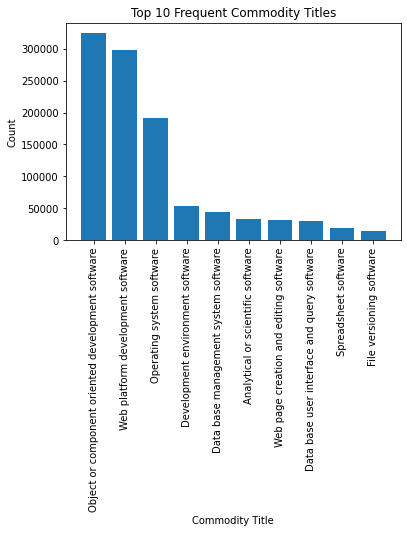

In [0]:
#Graphical representation of answer 6

import matplotlib.pyplot as plt
titles = joinedDF2.select("Commodity Title").limit(10).rdd.flatMap(lambda x: x).collect()
counts = joinedDF2.select("Count").limit(10).rdd.flatMap(lambda x: x).collect()
plt.bar(titles, counts)
plt.xticks(rotation=90)  
plt.xlabel("Commodity Title")
plt.ylabel("Count")
plt.title("Top 10 Frequent Commodity Titles")
plt.show()